In [3]:
import numpy as np
import matplotlib.pyplot as plt
from Network_bayesian import Place_net, Grid_net, Coupled_Net
import brainpy as bp
import brainpy.math as bm
from matplotlib.animation import FuncAnimation
import time
from scipy.stats import ttest_ind, norm

# 圆周距离函数
def circ_dis(phi_1, phi_2):
    dis = phi_1 - phi_2
    dis = np.where(dis > np.pi, dis - 2 * np.pi, dis)
    dis = np.where(dis < -np.pi, dis + 2 * np.pi, dis)
    return dis


In [4]:

# 默认参数
# grid spacing
lambda_1 = 3
lambda_2 = 4
lambda_3 = 5
Lambda = np.array([lambda_1, lambda_2, lambda_3])
L = lambda_1 * lambda_2 * lambda_3
# cell number
num_p = int(200)
rho_p = num_p / L
rho_g = rho_p
num_g = int(rho_g * 2 * np.pi)  # 为了让两个网络的rho相等
M = len(Lambda)
# feature space
x = np.linspace(0, L, num_p, endpoint=False)
theta = np.linspace(0, 2 * np.pi, num_g, endpoint=False)
# connection range
a_p = 0.3
a_g = a_p / Lambda * 2 * np.pi
# connection strength
J_p = 20
J_g = J_p
J_pg = J_p / 25


# divisive normalization
k_p = 20.
k_g = Lambda / 2 / np.pi * k_p
# time constants
tau_p = 1
tau_g = 2 * np.pi * tau_p / Lambda
# input_strength
alpha_p = 0.05
alpha_g = 0.05

noise_ratio = 0.007

P_CANN = Place_net(z_min=0, z_max=L, num=num_p, a_p=a_p, k=k_p, tau=tau_p, J0=J_p)
# Grid cells
G_CANNs = bm.NodeList()
for i in range(M):
    G_CANNs.append(Grid_net(z_min=0, z_max=L, num=num_g, num_hpc=num_p, L=Lambda[i], a_g=a_g[i], k_mec=k_g[i], tau=tau_g[i], J0=J_g, W0=J_pg))

Coupled_model = Coupled_Net(HPC_model=P_CANN, MEC_model_list=G_CANNs, num_module=M)

def GOP_decoding(z_t, phi_t, Ip, Ig, alpha_p_infer, alpha_g_infer, Ag, Ap, Rp, total_itenoise_rations=5000):
    sigma_g = np.sqrt(np.sqrt(np.pi) * Ag ** 3 * rho_g * tau_g / (a_g * alpha_g_infer))
    sigma_phi = np.sqrt(8 * np.pi * Ag * tau_g / (Lambda * J_pg * rho_p * Rp))
    sigma_p = np.sqrt(np.sqrt(np.pi) * Ap ** 3 * rho_p * tau_p / (a_p * alpha_p_infer))
    sigma_g_infer = sigma_g * noise_ratio
    sigma_phi_infer = sigma_phi * noise_ratio
    sigma_p_infer = sigma_p * noise_ratio
    eta = 20. * 1e-6
    z_ts = []
    phi_ts = []
    z_ts.append(z_t)
    phi_ts.append(phi_t)
    z_encode_space = np.linspace(0, L, num_p, endpoint=False)

    for itenoise_ration in range(total_itenoise_rations):
        fg_prime = np.zeros((M, num_g))
        for i in range(M):
            dis_theta = circ_dis(theta, phi_t[i])
            fg_prime[i, :] = dis_theta / (2 * a_g[i] ** 2) * np.exp(-dis_theta ** 2 / (4 * a_g[i] ** 2))

        dis_z = z_encode_space - z_t
        fp_prime = dis_z / (2 * a_p ** 2) * np.exp(-dis_z ** 2 / (4 * a_p ** 2))
        
        Ig_fgprime_prod = Ig * fg_prime
        Ig_fgprime_prod = np.sum(Ig_fgprime_prod, axis=1)
        dphi_fr = Ig_fgprime_prod / sigma_g_infer ** 2

        Ip_fp_prime_prod = Ip * fp_prime
        Ip_fp_prime_prod = np.sum(Ip_fp_prime_prod)
        dr_fr = Ip_fp_prime_prod / sigma_p_infer ** 2

        phi_z = np.mod(z_t / Lambda, 1) * 2 * np.pi
        dis_phi = circ_dis(phi_z, phi_t)
        dphi_tr = 1 / sigma_phi_infer ** 2 * dis_phi
        dr_tr = np.sum(-2 * np.pi / (Lambda * sigma_phi_infer ** 2) * dis_phi)

        dphi = dphi_fr + dphi_tr
        phi_t = phi_t + eta * dphi
        
        phi_t = np.mod(phi_t, 2 * np.pi)
        
        dr = dr_fr + dr_tr
        z_t = z_t + eta * dr

        z_ts.append(z_t)
        phi_ts.append(phi_t)
    return np.array(z_ts), np.array(phi_ts)

def Net_decoding(z_truth, phi_truth, Ip, Ig, alpha_p=0.05, alpha_g=0.05, Coupled_model=Coupled_model):
    Coupled_model.reset_state()
    def initial_net(Ip, Ig): 
        Coupled_model.initial(alpha_p=1, alpha_g=1, Ip=Ip, Ig=Ig)

    def run_net(i, Ip, Ig): 
        Coupled_model.step_run(i, alpha_p=1, alpha_g=1, Ip=Ip, Ig=Ig)
        phi_decode = Coupled_model.phase
        z_decode = Coupled_model.HPC_model.center
        rp = Coupled_model.HPC_model.r
        up = Coupled_model.HPC_model.u
        rg = bm.zeros([M, num_g])
        ug = bm.zeros([M, num_g])
        for mi in range(M):
            rg[mi, :] = Coupled_model.MEC_model_list[mi].r
            ug[mi, :] = Coupled_model.MEC_model_list[mi].u
        return z_decode, phi_decode, rp, up, rg, ug

    T_init = 500
    z0 = z_truth
    phi_0 = phi_truth
    fg = np.zeros((M, num_g))
    for i in range(M):
        dis_theta = circ_dis(theta, phi_0[i])
        fg[i, :] = np.exp(-dis_theta ** 2 / (4 * a_g[i] ** 2))
    dis_x = x - z0
    fp = np.exp(-dis_x ** 2 / (4 * a_p ** 2))
    I_place = 1 * np.repeat(fp[np.newaxis, :], T_init, axis=0)
    I_grid = 1 * np.repeat(fg[np.newaxis, :, :], T_init, axis=0)
    I_place[int(T_init / 3):, :] = 0
    I_grid[int(T_init / 3):, :, :] = 0

    bm.for_loop(initial_net, (I_place, I_grid), progress_bar=False)
    T = 5000
    indices = np.arange(T)
    I_place = alpha_p * np.repeat(Ip[np.newaxis, :], T, axis=0)
    I_grid = alpha_g * np.repeat(Ig[np.newaxis, :, :], T, axis=0)
    z_record, phi_record, rp, up, rg, ug = bm.for_loop(run_net, (indices, I_place, I_grid), progress_bar=False)

    return z_record, phi_record, up, rp, ug, rg


In [5]:

Ap = 1.0084058
Rp = 0.0128615275
Ag = 0.9814125
Rg = 0.013212965

sigma_g = np.sqrt(np.sqrt(np.pi)*Ag**3*rho_g*tau_g/(a_g*alpha_g)) * 0.01
sigma_phi = np.sqrt(8*np.pi*Ag*tau_g/(Lambda*J_pg*rho_p*Rp)) * 0.01
sigma_p = np.sqrt(np.sqrt(np.pi)*Ap**3*rho_p*tau_p/(a_p*alpha_p)) * 0.01
print(sigma_g, sigma_p, sigma_phi)

[0.19295613 0.19295613 0.19295613] 0.2009713795376621 [0.22407002 0.16805252 0.13444201]


In [6]:

# 主程序
neural_noise_sigma = 0.2
trial_num = 500
z_truth = 30
phi_truth = np.mod(z_truth / Lambda, 1) * 2 * np.pi 
sigma_phi = np.array([31.7,23.8,19])*neural_noise_sigma/20
z_decode_gop = np.zeros(trial_num)
z_decode_net = np.zeros(trial_num)
z_decode_net_motion = np.zeros(trial_num)
z_decode_net_visual = np.zeros(trial_num)

start_time = time.time()  # 记录开始时间

for i in range(trial_num):
    z_truth = 30
    phi_truth = np.mod(z_truth / Lambda, 1) * 2 * np.pi 
    z_e = z_truth
    psi = phi_truth + sigma_phi * np.random.randn(M)
    Ig = np.zeros((M, num_g))
    for j in range(M):
        dis_theta = circ_dis(theta, psi[j])
        Ig[j, :] = np.exp(-dis_theta ** 2 / (4 * a_g[j] ** 2)) + neural_noise_sigma * np.random.randn(num_g)
    dis_x = x - z_e
    Ip = np.exp(-dis_x ** 2 / (4 * a_p ** 2)) + neural_noise_sigma * np.random.randn(num_p) 
    z_decode_n, _, up, rp, ug, rg = Net_decoding(z_truth, phi_truth, Ip, Ig)

    max_up = np.max(up, axis=1)
    max_rp = np.max(rp, axis=1)
    Ap = np.max(max_up[-1])
    Rp = np.max(max_rp[-1])
    Ag = np.zeros(M,)
    Rg = np.zeros(M,)
    for mi in range(M):
        max_ug = np.max(ug[:, mi, :], axis=1)
        max_rg = np.max(rg[:, mi, :], axis=1)
        Ag[mi] = np.max(max_ug[-1])
        Rg[mi] = np.max(max_rg[-1])
    z_decode_g, _ = GOP_decoding(z_t=z_truth, phi_t=phi_truth, Ip=Ip, Ig=Ig, alpha_p_infer=0.05, alpha_g_infer=0.05, Ap=Ap, Rp=Rp, Ag=Ag)

    z_decode_mot, _, _, _, _, _ = Net_decoding(z_truth, phi_truth, Ip, Ig, alpha_p=0., alpha_g=0.05)
    z_decode_vis, _, _, _, _, _ = Net_decoding(z_truth, phi_truth, Ip, Ig, alpha_p=0.05, alpha_g=0.)

    z_decode_net_motion[i] = z_decode_mot[-1]
    z_decode_net_visual[i] = z_decode_vis[-1]

    z_decode_gop[i] = z_decode_g[-1]
    z_decode_net[i] = z_decode_n[-1]
    if i % 5 == 0:
        print(f"Progress: {i/trial_num*100:.2f}%")

end_time = time.time()  # 记录结束时间
print(f"Total runtime: {end_time - start_time:.2f} seconds")




Progress: 0.00%
Progress: 1.00%
Progress: 2.00%
Progress: 3.00%
Progress: 4.00%
Progress: 5.00%
Progress: 6.00%


In [ ]:

error_int_net = np.abs(z_decode_net-z_truth)
error_mot_net = np.abs(z_decode_net_motion-z_truth)
error_vis_net = np.abs(z_decode_net_visual-z_truth)
error_int_gop = np.abs(z_decode_gop-z_truth)

# 保存数据为npz文件
np.savez('decode_results.npz', z_decode_net=z_decode_net, z_decode_net_motion=z_decode_net_motion, z_decode_gop=z_decode_gop, z_decode_net_visual=z_decode_net_visual)
z_decode_all = np.concatenate([z_decode_net, z_decode_net_motion, z_decode_net_visual, z_decode_gop])
min_z = np.min(z_decode_all)
max_z = np.max(z_decode_all)
# 设置字体
plt.rcParams.update({'font.size': 12, 'font.family': 'Arial'})

# 画图


# 绘制z_decode_gop的直方图及高斯拟合
xmin, xmax = min_z, max_z

def gaussian_fit(data, xmin, xmax):
    mu, std = norm.fit(data)
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    return x, p

x_int_gop, p_int_gop = gaussian_fit(z_decode_gop, xmin, xmax)
x_int_net, p_int_net = gaussian_fit(z_decode_net, xmin, xmax)
x_mot_net, p_mot_net = gaussian_fit(z_decode_net_motion, xmin, xmax)
x_vis_net, p_vis_net = gaussian_fit(z_decode_net_visual, xmin, xmax)

# print('mean error gop integration:', np.mean(error_int_gop))
# print('mean error net integration:', np.mean(error_int_net))
# print('mean error net motion:', np.mean(error_mot_net))
# print('mean error net visual:', np.mean(error_vis_net))

sigma_1 =np.std(z_decode_net_motion)
sigma_2 =np.std(z_decode_net_visual)
sigma_3 = np.sqrt(1/(1/sigma_1**2 + 1/sigma_2**2))
print('mean error gop integration:', np.std(z_decode_gop))
print('mean error net integration:', np.std(z_decode_net))
print('mean error net motion:', np.std(z_decode_net_motion))
print('mean error net visual:', np.std(z_decode_net_visual))
print('mean error bayesian:', sigma_3)


plt.figure()
plt.plot(x_int_net, p_int_net/np.sum(p_int_net),label='integration')
plt.plot(x_mot_net, p_mot_net/np.sum(p_int_net),label='motion')
plt.plot(x_vis_net, p_vis_net/np.sum(p_int_net),label='visual')
plt.xlabel('Value')
plt.ylabel('Normalized Density')
plt.legend()
plt.savefig('figures\normalized_density.eps')
plt.tight_layout()
plt.show()

print(np.std(z_decode_net))


NameError: name 'np' is not defined

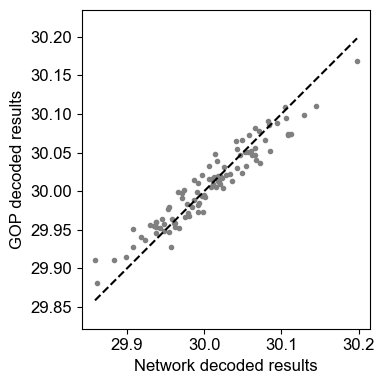

In [ ]:

# 设置字体
plt.rcParams.update({'font.size': 12, 'font.family': 'Arial'})

# 画图
plt.figure(figsize=(4, 4))
z_decode_all = np.concatenate([z_decode_gop, z_decode_net])
min_z = np.min(z_decode_all)
max_z = np.max(z_decode_all)

plt.plot(z_decode_net, z_decode_gop, '.', color='gray')
plt.plot([min_z, max_z], [min_z, max_z], 'k--')
plt.xlabel('Network decoded results')
plt.ylabel('GOP decoded results')
plt.axis('equal')  # 设置坐标轴比例相等
plt.tight_layout()
plt.savefig('net_gop_comparison.png')
plt.show()